# Question 3 Flower Classification using CNN 
- Please **do not** change the default variable names in this problem, as we will use them in different parts.
- The default variables are initially set to "None".
- You only need to modify code in the "TODO" part. We added some "assertions" to check your code. **Do not** modify them.

In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import torch 
import torch.optim as optim
import torch.nn as nn 
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import *
import random 
from tqdm import tqdm 
import warnings 

You can upload your image folder on Google drive and access image folder from it. **Skip it if you run on local machine.** To mount google drive to your current colab page, use the following command 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/flowers"

Mounted at /content/drive
/content/drive/MyDrive/flowers


In [2]:
# check pytorch cuda and use cuda if possible
device = torch.cuda.is_available()
print('*' * 50)
if torch.cuda.is_available():  
  print('CUDA is found! Tranining on %s.......'%torch.cuda.get_device_name(0))
else:
  warnings.warn('CUDA not found! Training may be slow......')

**************************************************
CUDA is found! Tranining on NVIDIA GeForce RTX 2080.......



## P1. Data augmentation and plotting
### TODO
- Design your image augmentation method for transform_image
- Load train and test data, and split them into train_loader and test_loader 
- Visualize your augmented image 





In [42]:
# TODO: define your image augmentation method
# Make sure to crop the image in (3,224,224) using transforms.RandomResizedCrop(224)  

transform_image = transforms.Compose([transforms.RandomResizedCrop(224), transforms.ToTensor()])


# TODO: Load data using ImageFolder. Specify your image folder path 
path = "flowers"
dataset = datasets.ImageFolder(path,transform=transform_image)

n = len(dataset)
n_test = int(0.1 * n) 


# Split data into features(pixels) and labels(numbers from 0 to 4)
train_dataset, test_dataset = random_split(dataset, (n-n_test,n_test))
train_loader, test_loader = DataLoader(train_dataset, batch_size=16, shuffle=True), DataLoader(test_dataset, batch_size=16, shuffle=True)


(-0.5, 223.5, 223.5, -0.5)

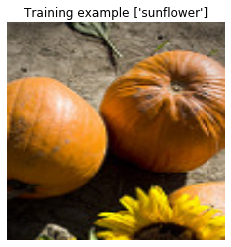

In [43]:
# Sample output
label_map = [['daisy'],['dandelion'],['rose'],['sunflower'],['tulip']]
random_image = random.randint(0,len(train_dataset))
image = train_dataset.__getitem__(random_image)
assert np.array_equal(image[0].detach().numpy().shape, [3,224,224])
plt.imshow(image[0].permute(1,2,0))
plt.title(f"Training example {label_map[image[1]]}")
plt.axis('off')

## P2. Build you own CNN model 
### TODO
- Design your own model class in **CNNModel(nn.Module)** and write forward pass in **forward(self, x)**
- Create loss function in **error**, optimizer in **optimizer**
- Define hyparparameters: **learning_rate**, **num_epochs**
- Plot your **loss vs num_epochs** and **accuracy vs num_epochs** 
- Plot your first convolution layer kernels using **plot_filters_multi_channel()**

###  Hints
- Start with low number of epochs for debugging. (eg. num_epochs=1)
- You may want to use small learning rate for training. (eg. 1e-5)
- Be careful with the input dimension of fully connected layer. 
- The dimension calculation of the output tensor from the input tensor is \\
$D_{out}=\frac{D_{in}-K+2P}{S}+1$ \\
$D_{out}$ : Dimension of output tensor \\
$D_{in}$ : Dimension of input tensor \\
$K$ : width/height of the kernel \\
$S$ : stride \\
$P$ : padding

## Convolutional and Pooling Layers

A convolutional layer using pyTorch:



```
torch.nn.Conv2d(num_in_channels, num_out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
```
For example:
```
torch.nn.Conv2d(3, 32, 3)
```
It applies a 2D convolution over an input signal composed of several input planes. If we have input size with $(N, C_{in}, H, W)$ and output size with $(N, C_{out}, H_{out}, W_{out})$, the 2D convolution can described as $$out(N_i, C_{out_j}) = bias(C_{out_j}) + \sum_{k=0}^{C_{in}-1}weight(C_{out_j},k)\star input(N_i,k)$$

**num_in_channels:** is the number of channels of the input tensor. If the previous layer is the input layer, num_in_channels is the number of channels of the image (3 channels for RGB images), otherwise num_in_channels is equal to the number of feature maps of the previous layer.

**num_out_channels:** is the number of filters (feature extractor) that this layer will apply over the image or feature maps generated by the previous layer.

**kernel_size:** is the size of the convolving kernel
So for instance, if we have an RGB image and we are going to apply 32 filters of 3x3:

**stide:** is the stride of the convolution. Default: 1

**padding:** is the padding added to all four sides of the input. Default: 0

**dilation:** is the spacing between kernel elements. Default: 1

**group:** is the number of blocked connections from input channels to output channels. Default: 1

**bias:** If True, adds a learnable bias to the output. Default: True

## A Simple Convolutional Neural Network

In our convnet we'll use the next structure shown in the comment:

*input -> convolution -> pooling -> fully connected -> output* \\

**Convolution #1**

16 kernels of 5x5; *Width/Height:* (224 - 5 + 2x0) / 1 + 1 = 220; *Output dimensions:* (16, 220, 220)

**Max Pooling #1**

filter size = 2, stride = 2; *Width/Height:* (220 - 2) / 2 + 1 = 110; *Output dimensions:* (16, 110, 110)

So at the end of the last convolutional layer we get a tensor of dimension (16, 110, 110). And since now we are going to feed it to fully connected classifier, we need to convert it into a 1-D vector, and for that we use the reshape method:

```
x = x.view(x.size(0), -1)
```
The way of calculating size of the output size from previous convolution layer can be formulized as below: $$H_{output} = \frac{H_{in}+2\times padding-kernel\_Size}{stride}+1$$

For more details, you can refer to this link: \\
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [44]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers 
    # Example:  
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
    self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
    self.cnn3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=5, stride=1, padding=2)
    self.relu1 = nn.ReLU() 
    self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2) 
    self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=1) 
    
    
    # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer 
    # Example: 
    self.fc1 = nn.Linear(16 * 26* 2* 26*2, 3000)
    # Fully connected 1
    
    # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer 
    # Example: 
    self.fc2 = nn.Linear(3000, 5)
    # Fully connected 2
  

  def forward(self,x):
    # TODO: Perform forward pass in below section 
    # Example:
    out = self.cnn1(x)
    out = self.relu1(out)      
    out = self.maxpool1(out) 

    out = self.cnn2(out)
    out = self.relu1(out)      
    out = self.maxpool1(out)

    out = self.cnn3(out)
    out = self.relu1(out)      
    out = self.maxpool2(out) 
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.fc2(out)
    
    
    return out

## Starting Up Our Model

We'll send the model to our GPU if you have one so we need to create a CUDA device and instantiate our model. Then we will define the loss function and 
hyperparameters that we need to train the model: \\

###TODO
- Define Cross Entropy Loss
- Create Adam Optimizer
- Define hyperparameters 

In [45]:
# Create CNN
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNModel()
model.to(device)
print(model)
# TODO: define Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 
learning_rate = 0.00001
optimizer = optim.Adam(model.parameters(), learning_rate)
num_epochs = 150

CNNModel(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (cnn3): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=43264, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=5, bias=True)
)


### Training the Model
### TODO 
- Make predictions from your model
- Calculate Cross Entropy Loss from predictions and labels 

In [48]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
flag = False
for epoch in tqdm(range(num_epochs)):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = model(images)
        
        # TODO: Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.argmax(outputs,1)
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        # if accuracy > 1:
        #   flag == True
        #   print(count)
        #   break
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))
    
    if accuracy_list[-1] > 70 and count > 2000:
      print(f"Run terminated, accuracy achieved: {accuracy_list[-1]}")
      break
    #del 
    #torch.cuda.empty_cache()

  1%|▏         | 2/150 [00:27<33:36, 13.63s/it]

Iteration: 500  Loss: 0.9089547395706177  Accuracy: 66.12528991699219 %


  3%|▎         | 4/150 [00:54<33:25, 13.74s/it]

Iteration: 1000  Loss: 0.8103935718536377  Accuracy: 66.82134246826172 %


  4%|▍         | 6/150 [01:22<33:03, 13.78s/it]

Iteration: 1500  Loss: 0.4477930963039398  Accuracy: 67.74942016601562 %


  5%|▌         | 8/150 [01:49<32:11, 13.60s/it]

Iteration: 2000  Loss: 1.2237461805343628  Accuracy: 62.6450080871582 %


  7%|▋         | 10/150 [02:17<32:00, 13.72s/it]

Iteration: 2500  Loss: 0.7431244850158691  Accuracy: 67.98143768310547 %


  8%|▊         | 12/150 [02:44<31:40, 13.77s/it]

Iteration: 3000  Loss: 0.41102105379104614  Accuracy: 64.50115966796875 %


  9%|▉         | 14/150 [03:12<31:13, 13.78s/it]

Iteration: 3500  Loss: 0.7422611117362976  Accuracy: 66.35730743408203 %


 11%|█         | 16/150 [03:39<30:29, 13.65s/it]

Iteration: 4000  Loss: 0.9277403354644775  Accuracy: 67.05335998535156 %


 12%|█▏        | 18/150 [04:06<30:06, 13.69s/it]

Iteration: 4500  Loss: 1.0011234283447266  Accuracy: 66.12528991699219 %


 13%|█▎        | 20/150 [04:34<29:45, 13.73s/it]

Iteration: 5000  Loss: 0.8367639780044556  Accuracy: 66.58932495117188 %


 15%|█▍        | 22/150 [05:01<28:57, 13.58s/it]

Iteration: 5500  Loss: 0.6749780774116516  Accuracy: 66.35730743408203 %


 16%|█▌        | 24/150 [05:28<28:45, 13.70s/it]

Iteration: 6000  Loss: 0.9666607975959778  Accuracy: 63.80510330200195 %


 17%|█▋        | 25/150 [05:56<29:41, 14.25s/it]

Run terminated, accuracy achieved: 70.53363800048828


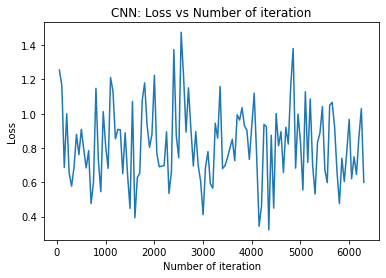

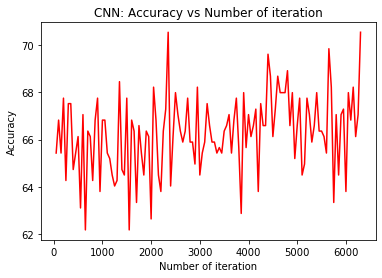

In [49]:
#tensor_array = embedding(input)
# the output of the line below is a numpy array
#tensor_array.cpu().detach().numpy()

# visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

### Evaluating the Model

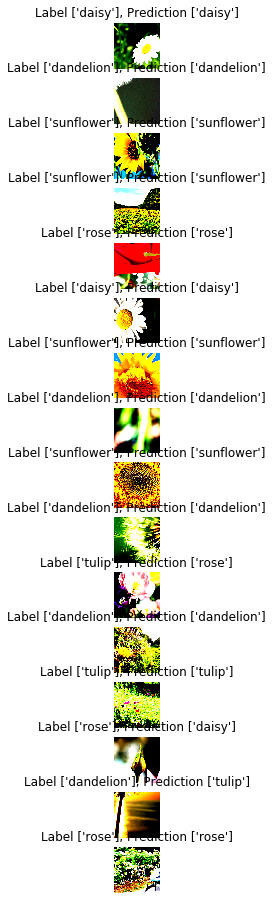

In [50]:
# Evaluate your model
random_image = random.randint(0,len(train_dataset))
image = train_dataset.__getitem__(random_image)
model.eval()
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
predictions = torch.argmax(model(images),1)
num_cols=1
num_rows = len(labels)
fig = plt.figure(figsize=(num_cols,num_rows))
for idx in range(num_rows):
  ax1 = fig.add_subplot(num_rows,num_cols,idx+1)
  img = images.cpu().detach()[idx].numpy()
  img = (img - np.mean(img)) / np.std(img)
  img = np.minimum(1, np.maximum(0, (img + 0.5)))
  ax1.imshow(img.transpose((1,2,0)))
  
  ax1.set_title(f"Label {label_map[labels[idx]]}, Prediction {label_map[predictions[idx]]}")
  ax1.axis('off')
plt.savefig('Prediction.png', dpi=100)    
plt.show()

### Visualizing your first layer filter 

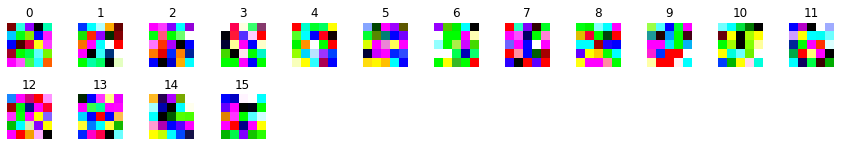

In [51]:
# plot your first layer kernels 

def plot_filters_multi_channel(t):
    #make sure the input channel is 3 
    assert(t.shape[1]==3)

    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12

    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].cpu().detach().numpy(), np.float32)
        
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('Filter.png', dpi=100)    
    plt.tight_layout()
    plt.show()

plot_filters_multi_channel(list(model.parameters())[0])

The above plot is for the second iteration of the model. The model was reran after 150 epochs and for this time the accuracy started from 60%. The accuracy >70% was achieved after 167th epoch (Here it shows 17).